In [1]:
import geopandas
import rasterio
import glob

In [2]:
# this will go in a loop for each site and each test plot. Now hardcoding
site = "MLBS"
plot_n = '4'
detection_path = './submission/'+site+'_submission.csv'
ras_path = './RS/'+site+'_'+plot_n+'.tif'
raster = rasterio.open(ras_path)

#if using RGB, we have 10 pixels per meter: if we are evaluating on RGB, we probably need to take into account if using w/l
pix_per_meter = 10
#automatically load only boxes within plots boundaries
gdf = geopandas.read_file(
    detection_path,
    bbox=raster.bounds,
)
gtf = geopandas.read_file(
    './submission/'+site+'_ground.csv',
    bbox=raster.bounds,
)

In [3]:
# turn WTK into coordinates within in the image
gdf_limits = gdf.bounds
gtf_limits = gtf.bounds

xmin = raster.bounds[0]
ymin = raster.bounds[1]
#xmax = raster.bounds[2]
#ymax = raster.bounds[3]

In [4]:
#length
gdf_limits['maxy'] = (gdf_limits['maxy'] - gdf_limits['miny'])*pix_per_meter
gtf_limits['maxy'] = (gtf_limits['maxy'] - gtf_limits['miny'])*pix_per_meter

#width
gdf_limits['maxx'] = (gdf_limits['maxx'] - gdf_limits['minx'])*pix_per_meter
gtf_limits['maxx'] = (gtf_limits['maxx'] - gtf_limits['minx'])*pix_per_meter

# translate coords to 0,0
gdf_limits['minx'] = (gdf_limits['minx'] - xmin) * pix_per_meter
gdf_limits['miny'] = (gdf_limits['miny'] - ymin) * pix_per_meter
gdf_limits.columns = ['minx', 'miny', 'width', 'length']

#same for groundtruth
gtf_limits['minx'] = (gtf_limits['minx'] - xmin) * pix_per_meter
gtf_limits['miny'] = (gtf_limits['miny'] - ymin) * pix_per_meter
gtf_limits.columns = ['minx', 'miny', 'width', 'length']

gdf_limits[gdf_limits < 0] = 0
gtf_limits[gtf_limits < 0] = 0


In [5]:
gdf_limits = gdf_limits.astype(int)
gtf_limits = gtf_limits.astype(int)

In [6]:
#save edges as a new csv file to be fed into the evaluation code
gdf_limits.to_csv('./eval/'+site+'_'+plot_n+'_detections_edges.csv')
gtf_limits.to_csv('./eval/'+site+'_'+plot_n+'_groundtruth_edges.csv')

In [7]:
gdf_limits

,minx,miny,width,length
0,71,131,51,49
1,124,138,43,40
2,69,88,77,53
3,92,27,65,81
4,153,54,46,83
5,0,94,71,77
6,2,20,84,92
7,0,0,54,61
8,56,0,95,66


In [18]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as pat
import scipy.io as sio
from PIL import Image
from rasterio.plot import show
import matplotlib as mpl

im = rasterio.open('./RS/MLBS_4.tif')

#GT = sio.loadmat('./RS/MLBS_4.tif')
#GT = GT['GT'][0]

In [19]:
groundboxes = np.loadtxt(open("./eval/MLBS_4_groundtruth_edges.csv", "rb"), 
                delimiter=",", skiprows=1,usecols = (1,2,3,4))



In [20]:
groundboxes = groundboxes.astype('int')
GT = groundboxes[0]
gdf_limits = gdf_limits.to_numpy()
detections = gdf_limits[5]


AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

In [21]:
print(GT)
print(gdf_limits[5])

[  1 155  41  43]
[ 0 94 71 77]


In [22]:
def halo_parameters(Nout,Nin,Nedge):
    par = {}
    par['inner'] = Nin  
    par['outer'] = Nout
    par['edge'] = Nedge
    par['plot'] = 1
    return par

def halo_corners(GT,im,par):

    #plot the inner halo
    innerCo = np.array([max(GT[0]+par['inner'], 0), max(GT[1]+par['inner'],0),
                            min(GT[2]-2*par['inner'], im.shape[0]), min(GT[3]-2*par['inner'], im.shape[0])])
    
    #plot the outer halo
    outerCo = np.array([max(GT[0]-par['outer'], 0),max(GT[1]-par['outer'],0),
                            min(GT[2]-2*par['outer'], im.shape[0]), min(GT[3]-2*par['outer'], im.shape[0])])

    
    #plot the edge halo
    edgeCo = np.array([max(GT[0]-par['edge'], 0),max(GT[1]-par['edge'],0),
                            min(GT[2]-2*par['edge'], im.shape[0]), min(GT[3]-2*par['edge'], im.shape[0])])    
    
    #plot the boxes
    if par['plot']:
        #fig,ax = plt.subplots(1)
        rasterio.plot.show((im, 1))
        ax = mpl.pyplot.gca()

        #show(im)
        
        #get GT rectangle
        rectGT = pat.Rectangle((GT[0],GT[1]),GT[2],GT[3],linewidth=2,edgecolor='r',fill=0)
        ax.add_patch(rectGT)
        
        #inner
        rectIn = pat.Rectangle((innerCo[0],innerCo[1]),innerCo[2],innerCo[3],linewidth=2,edgecolor='m',fill=0)
        ax.add_patch(rectIn)
        
        # outer
        rectOut = pat.Rectangle((outerCo[0],outerCo[1]),outerCo[2],outerCo[3],linewidth=2,edgecolor='tab:purple',fill=0)
        ax.add_patch(rectOut)
        
        #edge
        rectEdge = pat.Rectangle((edgeCo[0],edgeCo[1]),edgeCo[2],edgeCo[3],linewidth=2,edgecolor='tab:blue',fill=0)
        ax.add_patch(rectEdge)
    
    corners = {}
    corners['inner'] = innerCo
    corners['outer'] = outerCo
    corners['edge'] = edgeCo
    return corners,ax

def get_halo_indices(corners,im):
    
    halo_indices = {}
    
    #raster band to numpy 
    band1 = im.read(1)
    #get inner
    inxywh = corners['inner']
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,band1.shape)
    halo_indices['inner'] = set(indices)
    
    #get outer
    inxywh = corners['outer']
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,band1.shape)
    halo_indices['outer'] = set(indices)
    
    #get edge
    inxywh = corners['edge']
    x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
    y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,band1.shape)
    halo_indices['edge'] = set(indices)
    
    return halo_indices


def TestDet(par):
    return np.array([200,250,2*par['edge'],2*par['edge']])
#    return GT
    
def get_det_indices(det):
    x = np.arange(det[0], det[0]+det[2], 1)
    y = np.arange(det[1], det[1]+det[3], 1)
    X,Y = np.meshgrid(x,y)
    XY=np.array([X.flatten(),Y.flatten()])
    indices = np.ravel_multi_index(XY,im.shape)
    return set(indices)
    

def RandNeon(GT,detection,im,par):
    
    #get halos
    hcorners,ax = halo_corners(GT,im,par)
    
    #get sets for each halo
    halos = get_halo_indices(hcorners,im)
    
    #get set for detection
    det = get_det_indices(detection)
    
    #compute a
    a_set = det.intersection(halos['inner'])
    a = len(a_set)**2
    
    #compute b
    edge_wo = halos['edge'].difference(halos['outer'])
    b_set = edge_wo.difference(det)
    b = len(b_set)**2
    
    #compute c
    out_only = halos['edge'].difference(halos['outer'])
    c_set = det.intersection(out_only)
    c = len(c_set)**2
    
    #compute d
    det_in = det.intersection(halos['inner'])
    d_set = halos['inner'].difference(det_in)
    d = len(d_set)**2
    
    #plot detection
    if par['plot']:
        rectDet = pat.Rectangle((detection[0],detection[1]),detection[2],detection[3],linewidth=2,edgecolor='k',fill=0)
        ax.add_patch(rectDet)
        
    correct = a+b
    incorrect = c+d
    score = correct/(correct+incorrect)
    return score
    

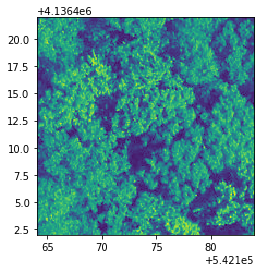

0.1999969040993165

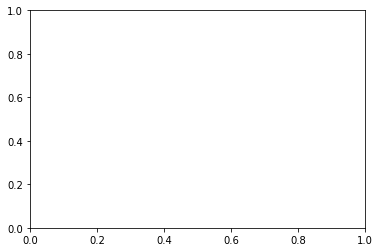

In [23]:
par = halo_parameters(5,5,20)
RandNeon(GT, detections, im, par)

In [ ]:
#get halos
hcorners,ax = halo_corners(GT,im,par)

#get sets for each halo
halos = get_halo_indices(hcorners,im)

In [ ]:
corners = hcorners

In [ ]:
halo_indices = {}

#get inner
inxywh = corners['inner']
x = np.arange(inxywh[0], inxywh[0]+inxywh[2], 1)
y = np.arange(inxywh[1], inxywh[1]+inxywh[3], 1)
X,Y = np.meshgrid(x,y)
XY=np.array([X.flatten(),Y.flatten()])
indices = np.ravel_multi_index(XY,im.shape)
halo_indices['inner'] = set(indices)

In [ ]:
np.ravel_multi_index(XY,(200,200))